# Applicant Ranking

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_jobs = pd.read_csv('jobs.csv')
df_resume = pd.read_csv('resume_sections.csv')
df_resume.drop(columns=['INTERESTS', 'AWARDS'], inplace=True)
df_resume.fillna('', inplace=True)

In [3]:
df_jobs

,title,description,skills,education,experience
0,Senior Backend Developer,We are seeking a highly skilled Senior Backend...,"Python, Django, RESTful APIs, SQL",Bachelor in Computer Engineering,3 years of software development experience in ...
1,Full Stack Developer,We are hiring a versatile Full Stack Developer...,"HTML, CSS, JavaScript, Node.js, Express, MongoDB",Bachelor Degree in Computer Science,2 years of data analysis experience using Exce...
2,Python Backend Engineer,We have an exciting opportunity for a Python B...,"Python, Django, Flask, SQL, AWS",Masters in Computer Science,4 years of marketing experience with a focus o...
3,Backend Software Engineer,We are looking for a talented Backend Software...,"Java, Spring, Hibernate, RESTful APIs, MySQL",PhD in Computer Science,2 years of web development experience using Dj...
4,Junior Backend Developer,We are seeking a motivated Junior Backend Deve...,"Python, Django, Git, Linux, SQL",Bachelor in Computer Engineering,1 year of data analytics experience with Table...


In [4]:
df_resume.head()

,EDUCATION,SKILLS,EXPERIENCE,PROFILE,PROJECTS,CERTIFICATIONS,Filename
0,Bachelor of Science Computer Science Oklahoma...,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...",Web Developer ICF 2020 - current / Oklahoma Ci...,,,,backend.pdf
1,"• Georgia Institute of Technology Atlanta, G...","• Languages : Scala, Python, Javascript, C++,...","• Google Mountain View, CA Software Engineer...",,• QuantSoftware Toolkit : Open source python ...,,latex0.pdf
2,Period January 2011 — February 2012 Degree Mas...,"Computer Languages Prolog, Haskell, AWK, Erlan...",Period March 2012 — Present Employer Layer BV ...,,,,latex1.pdf
3,,,,,,,latex2.pdf
4,"University of California, Berkeley June 2004 B...",,"ACME, Inc October 2010 - Present Web Developer...",,,,latex3.pdf


## Preprocessing

In [5]:
import re

def clean_description(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\+]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

clean_description("I have skills in developing applications using Python3, React.js, and JavaScript. I can use Java, express.JS!")

'i have skills in developing applications using python   react js  and javascript  i can use java  express js '

In [6]:
# Combine text from all columns to get overall resume text
df_resume['clean_resume_text'] = df_resume[['PROFILE', 'EXPERIENCE', 'PROJECTS', 'CERTIFICATIONS']].apply(lambda row: ' '.join(row), axis=1).apply(clean_description)
df_resume.head(-5)[['Filename', 'PROFILE', 'EXPERIENCE', 'PROJECTS', 'clean_resume_text']]

,Filename,PROFILE,EXPERIENCE,PROJECTS,clean_resume_text
0,backend.pdf,,Web Developer ICF 2020 - current / Oklahoma Ci...,,web developer icf current oklahoma c...
1,latex0.pdf,,"• Google Mountain View, CA Software Engineer...",• QuantSoftware Toolkit : Open source python ...,google mountain view ca software enginee...
2,latex1.pdf,,Period March 2012 — Present Employer Layer BV ...,,period march present employer layer bv...
3,latex2.pdf,,,,
4,latex3.pdf,,"ACME, Inc October 2010 - Present Web Developer...",,acme inc october present web develope...
5,node.pdf,,______________________________________________...,,...
6,react.pdf,,______________________________________________...,,...


# Choose target job

In [7]:
target_job = df_jobs.loc[2]

Preprocess job description  
This adds the title, and skills to the description.  
Then cleans it.

In [8]:
def preprocess_job(target_job):
    title, description, skills = (
        target_job['title'],
        target_job['description'],
        target_job['skills'],
    )    # Clean description
    if skills:
        description = skills.replace(',', '') + ' ' + description
    if title:
        description = f'{title} {description}'
    description = clean_description(description)
    # print('Cleaned job description:', description)
    return description

## Tfidf
For comparing job-description and resume-description

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:

def get_description_score(target_job):
    # Initialize the TfidfVectorizer
    # min_df=3 means ignore terms that appear in less than 3 document
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)

    # fit_transform the vectorizers and create tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([preprocess_job(target_job)] + df_resume['clean_resume_text'].values.tolist())
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    df_resume['description_score'] = cosine_similarities

In [11]:
get_description_score(target_job)

In [12]:
df_resume[['Filename', 'clean_resume_text', 'description_score']]

,Filename,clean_resume_text,description_score
0,backend.pdf,web developer icf current oklahoma c...,0.172757
1,latex0.pdf,google mountain view ca software enginee...,0.252097
2,latex1.pdf,period march present employer layer bv...,0.000000
3,latex2.pdf,,0.000000
4,latex3.pdf,acme inc october present web develope...,0.068269
5,node.pdf,...,0.052786
6,react.pdf,...,0.086157
7,resume2.pdf,effective student committed to learning devel...,0.159917
8,res_sp.pdf,highly motivated computer engineering student ...,0.210088
9,sw1.pdf,...,0.072936


## 1. Skills

#### How it works?
For each applicant, a binary vector is created where each element represents the presence (1) or absence (0) of a specific skill from the target job in the applicant's skills.

**Convert job description skills and applicant skills into binary feature vectors**

In [13]:
target_job['skills'].split(', ')

['Python', 'Django', 'Flask', 'SQL', 'AWS']

In [14]:
df_resume['SKILLS']

0     HTML CSS Javascript Python C++ SQL (MySQL, Pos...
1     •  Languages : Scala, Python, Javascript, C++,...
2     Computer Languages Prolog, Haskell, AWK, Erlan...
3                                                      
4                                                      
5     __________________________ Hard Skills: •  Sof...
6     ______________________________________________...
7     Fast Learner Highly Dependable Attention to De...
8     Programming Languages : JavaScript, Python, C/...
9     ______________________________________________...
10    ●  Technical Skills ●  Industry Knowledge ●  T...
11                                                     
Name: SKILLS, dtype: object

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# Helper function to check if a skill is present in the resume description
def skill_present(skill, description):
    # Use regular expression pattern matching to match the whole word
    pattern = r"\b" + re.escape(skill) + r"\b"
    return bool(re.search(pattern, description, re.IGNORECASE))


def vectorize_skills(df_resume_texts):
    # The 'skills' column has string values. Each string has skills sepearated by comma. So convert them to array of skills.
    target_job_skills = target_job['skills'].lower().split(', ')
    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=target_job_skills)

    # Create a list of skills for each applicant's project
    applicant_skills_vector = df_resume_texts.apply(lambda x: [skill for skill in target_job_skills if skill_present(skill, x)])

    # Use the MultiLabelBinarizer to transform the 'skills' column into binary vectors
    applicant_binary_vectors = mlb.fit_transform(applicant_skills_vector)

    return applicant_binary_vectors.tolist()


In [16]:
df_resume['skills_vector'] = vectorize_skills(df_resume['SKILLS'])
df_resume[['Filename', 'SKILLS', 'skills_vector']]

,Filename,SKILLS,skills_vector
0,backend.pdf,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...","[1, 0, 0, 1, 0]"
1,latex0.pdf,"• Languages : Scala, Python, Javascript, C++,...","[1, 0, 0, 1, 1]"
2,latex1.pdf,"Computer Languages Prolog, Haskell, AWK, Erlan...","[0, 0, 0, 1, 0]"
3,latex2.pdf,,"[0, 0, 0, 0, 0]"
4,latex3.pdf,,"[0, 0, 0, 0, 0]"
5,node.pdf,__________________________ Hard Skills: • Sof...,"[0, 0, 0, 0, 0]"
6,react.pdf,______________________________________________...,"[0, 0, 0, 0, 0]"
7,resume2.pdf,Fast Learner Highly Dependable Attention to De...,"[0, 0, 0, 0, 0]"
8,res_sp.pdf,"Programming Languages : JavaScript, Python, C/...","[1, 1, 0, 1, 0]"
9,sw1.pdf,______________________________________________...,"[0, 0, 0, 0, 0]"


In [17]:
target_job['skills_vector'] = np.ones(len(target_job['skills'].split(', ')))
target_job.skills, target_job.skills_vector

('Python, Django, Flask, SQL, AWS', array([1., 1., 1., 1., 1.]))

In [18]:
def get_skills_score():
    target_vector = np.array(target_job['skills_vector']).reshape(1, -1)
    applicant_vector = np.array(df_resume['skills_vector'].tolist())
    similarity_scores = cosine_similarity(target_vector, applicant_vector)
    df_resume['skills_score'] = similarity_scores.flatten()

# target_vector is created from target_job['skills_vector']. It's reshaped to a 2D array with reshape(1, -1) because cosine_similarity expects a 2D array.
# applicant_vectors is created by converting df_resume['skills_vector'] to a NumPy array using tolist(). This is done because cosine_similarity expects a 2D array.

In [19]:
get_skills_score()

In [20]:
df_resume[['Filename', 'SKILLS', 'skills_vector', 'skills_score']]

,Filename,SKILLS,skills_vector,skills_score
0,backend.pdf,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...","[1, 0, 0, 1, 0]",0.632456
1,latex0.pdf,"• Languages : Scala, Python, Javascript, C++,...","[1, 0, 0, 1, 1]",0.774597
2,latex1.pdf,"Computer Languages Prolog, Haskell, AWK, Erlan...","[0, 0, 0, 1, 0]",0.447214
3,latex2.pdf,,"[0, 0, 0, 0, 0]",0.000000
4,latex3.pdf,,"[0, 0, 0, 0, 0]",0.000000
5,node.pdf,__________________________ Hard Skills: • Sof...,"[0, 0, 0, 0, 0]",0.000000
6,react.pdf,______________________________________________...,"[0, 0, 0, 0, 0]",0.000000
7,resume2.pdf,Fast Learner Highly Dependable Attention to De...,"[0, 0, 0, 0, 0]",0.000000
8,res_sp.pdf,"Programming Languages : JavaScript, Python, C/...","[1, 1, 0, 1, 0]",0.774597
9,sw1.pdf,______________________________________________...,"[0, 0, 0, 0, 0]",0.000000


## 2. Projects

#### How it works?
***It checks if the applicant has made at least one project using the required skills or not.***

1. The job description skills are converted into a binary feature vector, where each element represents the presence or absence of a skill in the job description.

2. A helper function skill_present is defined to check if a skill is present in the project description using regular expression pattern matching to match the whole word.

3. The vectorize_project function takes the applicant projects and job skills as input and converts the project descriptions into binary feature vectors. For each applicant, it iterates over the skills and checks if any of the skills are present in the project descriptions using the skill_present function.

4. The cosine similarity is calculated between the job_skills_vector and each applicant's project vector using the cosine_similarity function. The similarity score represents how closely the applicant's projects match the job description skills.

Testing the vectorization of projects description

In [21]:
projects = [
    'i have done project in (python, django rest).', 
    ' javaScript, node.js, reactjs',
    ' py. django-rest, r(java), NodeJS. '
]
projects = pd.Series(projects)
app_vec = projects.apply(lambda x: [skill for skill in ['Python', 'Django', 'Django rest', 'java', 'js', 'react', 'nodejs'] if skill_present(skill, x)])
print(app_vec)

0    [Python, Django, Django rest]
1                             [js]
2           [Django, java, nodejs]
dtype: object


In [22]:
# Convert applicant projects into binary feature vectors
df_resume['projects_vector'] = vectorize_skills(df_resume['PROJECTS'])

In [23]:
def get_projects_score():
    target_vector = np.array(target_job['skills_vector']).reshape(1, -1)
    applicant_vector = np.array(df_resume['projects_vector'].tolist())
    similarity_scores = cosine_similarity(target_vector, applicant_vector)
    df_resume['projects_score'] = similarity_scores.flatten()

# target_vector is created from target_job['skills_vector']. It's reshaped to a 2D array with reshape(1, -1) because cosine_similarity expects a 2D array.
# applicant_vectors is created by converting df_resume['projects_vector'] to a NumPy array using tolist(). This is done because cosine_similarity expects a 2D array.

In [24]:
get_projects_score()

In [25]:
df_resume[['Filename', 'PROJECTS', 'projects_vector', 'projects_score']]

,Filename,PROJECTS,projects_vector,projects_score
0,backend.pdf,,"[0, 0, 0, 0, 0]",0.000000
1,latex0.pdf,• QuantSoftware Toolkit : Open source python ...,"[1, 0, 0, 0, 0]",0.447214
2,latex1.pdf,,"[0, 0, 0, 0, 0]",0.000000
3,latex2.pdf,,"[0, 0, 0, 0, 0]",0.000000
4,latex3.pdf,,"[0, 0, 0, 0, 0]",0.000000
5,node.pdf,,"[0, 0, 0, 0, 0]",0.000000
6,react.pdf,,"[0, 0, 0, 0, 0]",0.000000
7,resume2.pdf,Kukurshetra A cross platform desktop app writt...,"[1, 0, 1, 0, 0]",0.632456
8,res_sp.pdf,Hire Nepal Job Portal Website • This website o...,"[0, 1, 0, 0, 0]",0.447214
9,sw1.pdf,,"[0, 0, 0, 0, 0]",0.000000


## 3. Education

### Identify Degree and Major in Education

Our system uses spacy library to extract information (degree and major) from Education. We prepared a dictionary that has all education degrees and majors related to computer engineering field. We fed that dictionary to the Spacy rule-based EntityRuler in order to detect and recognize entities in our job description.

In [26]:
import spacy
from spacy import displacy

In [27]:
def match_degrees_by_spacy(education_text, nlp):
    doc = nlp(education_text)
    degree_levels = []
    for ent in doc.ents:
        labels_parts = ent.label_.split('|')
        if labels_parts[0] == 'DEGREE':
            # print((ent.text, ent.label_))
            if labels_parts[1] not in degree_levels:
                degree_levels.append(labels_parts[1])
    return degree_levels


def match_majors_by_spacy(education_text, nlp):
    doc = nlp(education_text)
    acceptable_majors = []
    for ent in doc.ents:
        labels_parts = ent.label_.split('|')
        if labels_parts[0] == 'MAJOR':
            if labels_parts[2].replace('-', ' ') not in acceptable_majors:
                acceptable_majors.append(labels_parts[2].replace('-', ' '))
            if labels_parts[2].replace('-', ' ') not in acceptable_majors:
                acceptable_majors.append(labels_parts[2].replace('-', ' '))
    return acceptable_majors

In [28]:
df_resume['EDUCATION'][5], target_job['education']

('__________________________ University of New York Associate of Applied Science Computer Programming New York City, New York 10/2011 - 06/2014 OTHER ___________________________ •  Node.js Application Developer Certiﬁcation •  Certiﬁed Node.js Developer (CND) ',
 'Masters in Computer Science')

In [29]:
# Function to extract degree level and field of study from education
def extract_education_info():
    # Initialize the NLP pipeline and entity ruler
    nlp = spacy.load("en_core_web_sm")
    ruler = nlp.add_pipe("entity_ruler", before='ner')

    # Load the degree and major patterns
    ruler.from_disk('degrees_majors.jsonl')

    # Initialize lists to store the results
    resume_degrees = []
    resume_majors = []

    # Extract degree and major for each resume
    for education_text in df_resume['EDUCATION']:
        degrees = match_degrees_by_spacy(education_text, nlp)
        majors = match_majors_by_spacy(education_text, nlp)
        resume_degrees.append(degrees)
        resume_majors.append(majors)
    
    # Extract degree and major for the target job
    job_degree = match_degrees_by_spacy(target_job['education'], nlp)
    job_major = match_majors_by_spacy(target_job['education'], nlp)

    df_resume['education_degree'], df_resume['education_major'], target_job['education_degree'], target_job['education_major'] = resume_degrees, resume_majors, job_degree, job_major
    
    return resume_degrees, resume_majors, job_degree, job_major

#### How it works?
It considers two factors seperately: degree and field of study.

1. Degree
- Values are assigned to different degree levels. Eg: Bachelor=1, Master=2, PhD=3
- A lower degree score indicates better similarity, with 0 being the best possible score.
- Normalize the score to be between 0 and 1 and adjust such that a higher score indicates better similarity.

2. Field of Study
- measures the text similarity between the applicant's field of study and the job's required field of study.
3. Combining Degree and Field Scores
The degree score is weighted by 0.7, and the field score is weighted by 0.3.


Education Degree Score

In [30]:
# Define a mapping for degree levels
degree_mapping = {
    'BACHELOR': 1,
    'MASTER': 2,
    'PHD': 3,
}

def get_education_degree_score(resume_degrees, job_degree):
    # Apply the mapping to the list of degrees
    numerical_degrees = [[degree_mapping.get(degree, 0) for degree in degrees] for degrees in resume_degrees]
    # Get the highest degree for each resume
    applicant_degrees = [max(degrees) if degrees else 0 for degrees in numerical_degrees]

    # Convert the job degree to numerical form
    numerical_job_degree = [degree_mapping.get(degree, 0) for degree in job_degree]
    # Get the minimum degree required for the job
    min_degree_required = min(numerical_job_degree)

    degree_scores = []
    for applicant_degree in applicant_degrees:
        degree_score = 0
        
        if applicant_degree >= min_degree_required:
            degree_score = 0
        else:
            degree_score = min_degree_required-applicant_degree

        # smaller degree score means greater similarity (0 means exact)
        # the max_degree_score may be 2 (eg: phd vs bachelor)
        max_degree_score = 2 
        # By dividing (max_score - degree_score) by max_score, you normalize the score to be between 0 and 1, where a higher score indicates better similarity.
        degree_score = (max_degree_score - degree_score) / max_degree_score

        degree_scores.append(degree_score)

    return degree_scores
        

Education Major (Field of Study) Score

In [31]:
from difflib import SequenceMatcher

# Function to calculate text similarity using SequenceMatcher
def calculate_education_major_similarity(str1, str2):
    return SequenceMatcher(None, str1.lower(), str2.lower()).ratio()

def get_education_major_score(resume_majors, job_major):
    field_scores = []

    for resume_major in resume_majors:
        # Convert resume_major array to string separated by ' '
        applicant_major = ' '.join(resume_major)
        field_score = 0
        similarities = [calculate_education_major_similarity(applicant_major, required_major) for required_major in job_major]
        # Find max similarity score
        if similarities:
            field_score = max(similarities)
        field_scores.append(field_score)

    return field_scores   

Education Score by combining degree and majors score

In [32]:
def get_education_score():
    resume_degrees, resume_majors, job_degree, job_major = extract_education_info()

    degree_scores = get_education_degree_score(resume_degrees, job_degree)
    field_scores = get_education_major_score(resume_majors, job_major)

    # Set weights for degree and field_of_study
    degree_weight = 0.7
    field_weight = 0.3

    combined_scores = [degree_weight * degree_score + field_weight * field_score for degree_score, field_score in zip(degree_scores, field_scores)]

    df_resume['education_score'] = combined_scores


In [33]:
get_education_score()

In [34]:
target_job[['education', 'education_degree', 'education_major']]

education           Masters in Computer Science
education_degree                       [MASTER]
education_major              [computer science]
Name: 2, dtype: object

In [35]:
df_resume[['Filename', 'EDUCATION', 'education_degree', 'education_major', 'education_score']]

,Filename,EDUCATION,education_degree,education_major,education_score
0,backend.pdf,Bachelor of Science Computer Science Oklahoma...,[BACHELOR],[computer science],0.650000
1,latex0.pdf,"• Georgia Institute of Technology Atlanta, G...","[MASTER, BACHELOR]",[computer science],1.000000
2,latex1.pdf,Period January 2011 — February 2012 Degree Mas...,"[MASTER, BACHELOR]",[computer science],1.000000
3,latex2.pdf,,[],[],0.000000
4,latex3.pdf,"University of California, Berkeley June 2004 B...",[BACHELOR],[computer science],0.650000
5,node.pdf,__________________________ University of New Y...,[BACHELOR],[computer programming],0.533333
6,react.pdf,______________________________________________...,[BACHELOR],[computer science],0.650000
7,resume2.pdf,Bachelor in Computer Engineering November 2017...,[BACHELOR],[computer engineering],0.550000
8,res_sp.pdf,Bachelor in Computer Engineering Pulchowk Camp...,[BACHELOR],[computer engineering],0.550000
9,sw1.pdf,______________________________________________...,"[BACHELOR, MASTER]",[computer science],1.000000


## 4. Experience

- Extracts the 'X years' part from the target job experience.
- Calculates similarity scores for each applicant's experience, taking the ratio of their 'X years' to the target job's 'X years'. 
- The score is limited it to a maximum of 1.0 to avoid giving excessive credit to applicants with more experience than needed.

In [36]:
df_resume['EXPERIENCE'][7]

'Nepal Applied Mathematics and Informatics Institute for Research (NAAMII) June 2020 — Present IEEE Pulchowk Student Branch Feb 2020 — Present Locus, Nepal February 2020 Locus, Nepal February 2019 Locus, Nepal February 2018 Research Intern I am currently working under diyo.ai to build Nepali Language Text Corpus. Event Chair Organized Tech Talk on "A Platform for Innovations and Ideas" with the CEO of Yatri Motorcycles and the CEO of International Green Developers Nepal as the speakers of the session. Organizer Organized  RoboWarz , a popular event of one of the largest technological festival of Nepal, Locus. Robots from different places of Nepal came to battle with each other Participant Built an Android app named,  Smart Counter  which booked tickets of a certain bus company and showed which seats are booked, sold and available. Flask was used as server and React Native was used to program Android application. Participant Made an  Air Quality Sensing Device  that measured the quality

Minimum years of experience for target job

In [37]:
import re

# Function to extract years of exp from job description
def extract_min_experience(text):
    # Define the regular expression patterns
    pattern_months = r'(\d+)(?=\s*month)'
    pattern_years = r'(\d+)(?=\s*year)'
    
    # Use search to get the first match
    match_years = re.search(pattern_years, text)
    match_months = re.search(pattern_months, text)
    
    # If a match was found, convert it to an integer and return
    if match_years:
        return int(match_years.group())
    elif match_months:
        return int(match_months.group()) / 12  # Convert months to years
    
    # If no match was found, return None
    return 0

# Convert job experience to 'X years' information
extract_min_experience(target_job['experience'])

4

Create EntityRuler to extract dates from experience information

In [38]:
import spacy

def create_nlp_for_experience():
    nlp = spacy.load("en_core_web_sm")

    # Most of the date patterns are detected by default DATE entity
    # Define the pattern for '05/2015 - 06/2017' and '10/2020 - Present'.
    patterns = [
        # 05/2015 - 06/2017
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"SHAPE": "dd/dddd"}]},

        # 10/2020 - Present
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"LOWER": "present"}]},
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"LOWER": "current"}]},

        # Jan 2020 - current, March 2018 - Present
        {"label": "DATE", "pattern": [{"LOWER": {"in": ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec", "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]}}, {"TEXT": {"REGEX": "^\d{4}$"}}, {"TEXT": "-"}, {"LOWER": {"in": ["current", "present"]}}]},

        # 2020 - current
        {"label": "DATE", "pattern": [{"SHAPE": "dddd"}, {"TEXT": "-"}, {"LOWER": {"in": ["current", "present"]}}]},
        ]

    ruler = nlp.add_pipe("entity_ruler", before='ner')
    # Add the pattern to the ruler
    ruler.add_patterns(patterns)

    return nlp

Calculate years of experience from applicant's resume

In [39]:
from dateutil import parser
from dateutil.relativedelta import relativedelta
from datetime import datetime

def extract_years(dates):
    years = 0
    for date in dates:
        # Check if the date is in the "start - end" format
        if ' - ' not in date:
            continue
        
        # Split the date range into start and end dates
        start_date, end_date = date.split(' - ')
        
        # Replace 'Present' or 'current' with today's date
        if 'present' in end_date.lower() or 'current' in end_date.lower():
            end_date = datetime.today().strftime('%m/%Y')
        
        # Parse the dates
        start_date = parser.parse(start_date)
        end_date = parser.parse(end_date)
        
        # Calculate the difference in years (considering months)
        diff = relativedelta(end_date, start_date)
        years += round(diff.years + diff.months / 12, 2)
        
    return years

In [40]:
def get_experience_score():
    target_job_experience = extract_min_experience(target_job['experience'])
    
    nlp = create_nlp_for_experience()

    # First, replace En-dash '–' with Hyphen '-' before NER. e.g. Jun 2018 – Present
    df_resume['EXPERIENCE'] = df_resume['EXPERIENCE'].str.replace('–', '-')

    experience_date_vectors = []
    # Calculate similarity scores for each applicant
    applicant_scores = []
    for applicant_experience in df_resume['EXPERIENCE']:
        doc = nlp(applicant_experience)

        # Extract the dates that are in the 'start - end' format
        extracted_dates = [ent.text for ent in doc.ents if ent.label_ == 'DATE' and ' - ' in ent.text]
        experience_date_vectors.append(extracted_dates)

        applicant_years = extract_years(extracted_dates)

        if target_job_experience == 0: # no experience requireed
            similarity_score = 1.0
        else:  
            similarity_score = min(applicant_years / target_job_experience, 1.0)
        applicant_scores.append(similarity_score)

    df_resume['experience_dates'] = experience_date_vectors
    df_resume['experience_score'] = applicant_scores

In [41]:
get_experience_score()

In [42]:
target_job['experience']

'4 years of marketing experience with a focus on social media marketing and SEO.'

In [43]:
df_resume[['Filename', 'EXPERIENCE', 'experience_dates', 'experience_score']]

,Filename,EXPERIENCE,experience_dates,experience_score
0,backend.pdf,Web Developer ICF 2020 - current / Oklahoma Ci...,"[2020 - current, 2017 - 2020, 2015 - 2017]",1.0
1,latex0.pdf,"• Google Mountain View, CA Software Engineer...","[Oct 2016 - Present, Jan 2014 - Oct 2016]",1.0
2,latex1.pdf,Period March 2012 — Present Employer Layer BV ...,[],0.0
3,latex2.pdf,,[],0.0
4,latex3.pdf,"ACME, Inc October 2010 - Present Web Developer...","[October 2010 - Present, December 2009 - Octob...",1.0
5,node.pdf,______________________________________________...,"[08/2021 - Present, 10/2019 - 07/2021, 11/2018...",1.0
6,react.pdf,______________________________________________...,"[09/2015 - Present, 10/2012 - 08/2015, 07/2010...",1.0
7,resume2.pdf,Nepal Applied Mathematics and Informatics Inst...,[],0.0
8,res_sp.pdf,Backend Developer Startup Company : GradeUp Ed...,[],0.0
9,sw1.pdf,______________________________________________...,"[09/2015 - Present, 12/2012 - 08/2015, 10/2010...",1.0


#### Finally, so far

In [44]:
df_resume.head()

,EDUCATION,SKILLS,EXPERIENCE,PROFILE,PROJECTS,CERTIFICATIONS,Filename,clean_resume_text,description_score,skills_vector,skills_score,projects_vector,projects_score,education_degree,education_major,education_score,experience_dates,experience_score
0,Bachelor of Science Computer Science Oklahoma...,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...",Web Developer ICF 2020 - current / Oklahoma Ci...,,,,backend.pdf,web developer icf current oklahoma c...,0.172757,"[1, 0, 0, 1, 0]",0.632456,"[0, 0, 0, 0, 0]",0.000000,[BACHELOR],[computer science],0.65,"[2020 - current, 2017 - 2020, 2015 - 2017]",1.0
1,"• Georgia Institute of Technology Atlanta, G...","• Languages : Scala, Python, Javascript, C++,...","• Google Mountain View, CA Software Engineer...",,• QuantSoftware Toolkit : Open source python ...,,latex0.pdf,google mountain view ca software enginee...,0.252097,"[1, 0, 0, 1, 1]",0.774597,"[1, 0, 0, 0, 0]",0.447214,"[MASTER, BACHELOR]",[computer science],1.00,"[Oct 2016 - Present, Jan 2014 - Oct 2016]",1.0
2,Period January 2011 — February 2012 Degree Mas...,"Computer Languages Prolog, Haskell, AWK, Erlan...",Period March 2012 — Present Employer Layer BV ...,,,,latex1.pdf,period march present employer layer bv...,0.000000,"[0, 0, 0, 1, 0]",0.447214,"[0, 0, 0, 0, 0]",0.000000,"[MASTER, BACHELOR]",[computer science],1.00,[],0.0
3,,,,,,,latex2.pdf,,0.000000,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,[],[],0.00,[],0.0
4,"University of California, Berkeley June 2004 B...",,"ACME, Inc October 2010 - Present Web Developer...",,,,latex3.pdf,acme inc october present web develope...,0.068269,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,[BACHELOR],[computer science],0.65,"[October 2010 - Present, December 2009 - Octob...",1.0


- `calculate_total_score()` computes weighted total scores for resumes by combining attributes such as description, skills, projects, education, and experience. 
- Then, it sorts resumes based on these scores.

In [45]:
def calculate_total_score():
    description_weight = 0.2
    skills_weight = 0.3
    projects_weight = 0.2
    education_weight = 0.15
    experience_weight = 0.15

    df_resume['total_score'] = df_resume['description_score']*description_weight + df_resume['skills_score']*skills_weight + df_resume['projects_score']*projects_weight + df_resume['education_score']*education_weight + df_resume['experience_score']*experience_weight

    # Sort the DataFrame based on total_score in descending order
    df_resume_rankings_sorted = df_resume.sort_values(by='total_score', ascending=False)

    display(df_resume_rankings_sorted)

In [46]:
calculate_total_score()

,EDUCATION,SKILLS,EXPERIENCE,PROFILE,PROJECTS,CERTIFICATIONS,Filename,clean_resume_text,description_score,skills_vector,skills_score,projects_vector,projects_score,education_degree,education_major,education_score,experience_dates,experience_score,total_score
1,"• Georgia Institute of Technology Atlanta, G...","• Languages : Scala, Python, Javascript, C++,...","• Google Mountain View, CA Software Engineer...",,• QuantSoftware Toolkit : Open source python ...,,latex0.pdf,google mountain view ca software enginee...,0.252097,"[1, 0, 0, 1, 1]",0.774597,"[1, 0, 0, 0, 0]",0.447214,"[MASTER, BACHELOR]",[computer science],1.000000,"[Oct 2016 - Present, Jan 2014 - Oct 2016]",1.0,0.672241
0,Bachelor of Science Computer Science Oklahoma...,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...",Web Developer ICF 2020 - current / Oklahoma Ci...,,,,backend.pdf,web developer icf current oklahoma c...,0.172757,"[1, 0, 0, 1, 0]",0.632456,"[0, 0, 0, 0, 0]",0.000000,[BACHELOR],[computer science],0.650000,"[2020 - current, 2017 - 2020, 2015 - 2017]",1.0,0.471788
8,Bachelor in Computer Engineering Pulchowk Camp...,"Programming Languages : JavaScript, Python, C/...",Backend Developer Startup Company : GradeUp Ed...,Highly motivated Computer Engineering student ...,Hire Nepal Job Portal Website • This website o...,,res_sp.pdf,highly motivated computer engineering student ...,0.210088,"[1, 1, 0, 1, 0]",0.774597,"[0, 1, 0, 0, 0]",0.447214,[BACHELOR],[computer engineering],0.550000,[],0.0,0.446339
9,______________________________________________...,______________________________________________...,______________________________________________...,,,,sw1.pdf,...,0.072936,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,"[BACHELOR, MASTER]",[computer science],1.000000,"[09/2015 - Present, 12/2012 - 08/2015, 10/2010...",1.0,0.314587
10,"Resume Worded University, San Francisco, CA M...",● Technical Skills ● Industry Knowledge ● T...,"Resume Worded , New York, NY Jun 2018 - Presen...",,,,sw2.pdf,resume worded new york ny jun prese...,0.147090,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,"[BACHELOR, MASTER]",[information technology],0.794737,"[Jun 2018 - Present, Jan 2015 - May 2018, June...",1.0,0.298628
2,Period January 2011 — February 2012 Degree Mas...,"Computer Languages Prolog, Haskell, AWK, Erlan...",Period March 2012 — Present Employer Layer BV ...,,,,latex1.pdf,period march present employer layer bv...,0.000000,"[0, 0, 0, 1, 0]",0.447214,"[0, 0, 0, 0, 0]",0.000000,"[MASTER, BACHELOR]",[computer science],1.000000,[],0.0,0.284164
6,______________________________________________...,______________________________________________...,______________________________________________...,,,,react.pdf,...,0.086157,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,[BACHELOR],[computer science],0.650000,"[09/2015 - Present, 10/2012 - 08/2015, 07/2010...",1.0,0.264731
4,"University of California, Berkeley June 2004 B...",,"ACME, Inc October 2010 - Present Web Developer...",,,,latex3.pdf,acme inc october present web develope...,0.068269,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,[BACHELOR],[computer science],0.650000,"[October 2010 - Present, December 2009 - Octob...",1.0,0.261154
7,Bachelor in Computer Engineering November 2017...,Fast Learner Highly Dependable Attention to De...,Nepal Applied Mathematics and Informatics Inst...,"Effective Student committed to learning, devel...",Kukurshetra A cross platform desktop app writt...,Deep Learning Specialization by deeplearning....,resume2.pdf,effective student committed to learning devel...,0.159917,"[0, 0, 0, 0, 0]",0.000000,"[1, 0, 1, 0, 0]",0.632456,[BACHELOR],[computer engineering],0.550000,[],0.0,0.240974
5,__________________________ University of New Y...,__________________________ Hard Skills: • Sof...,______________________________________________...,,,,node.pdf,...,0.052786,"[0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0]",0.000000,[BACHELOR],[computer programming],0.533333,"[08/2021 - Pre

## Visualization

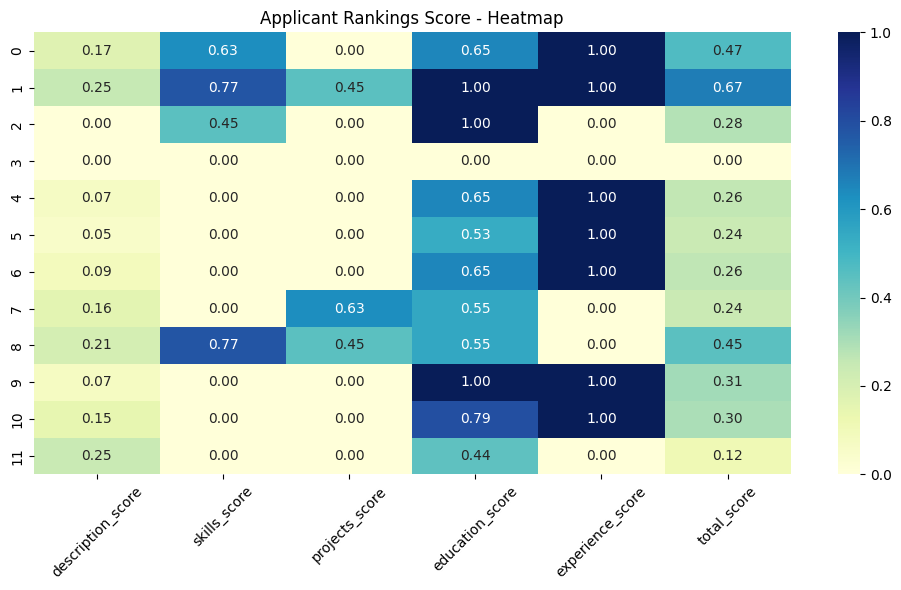

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_heatmap(df):
    columns_to_visualize = ['description_score', 'skills_score', 'projects_score', 'education_score', 'experience_score', 'total_score']
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[columns_to_visualize], cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title('Applicant Rankings Score - Heatmap')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_heatmap(df_resume)

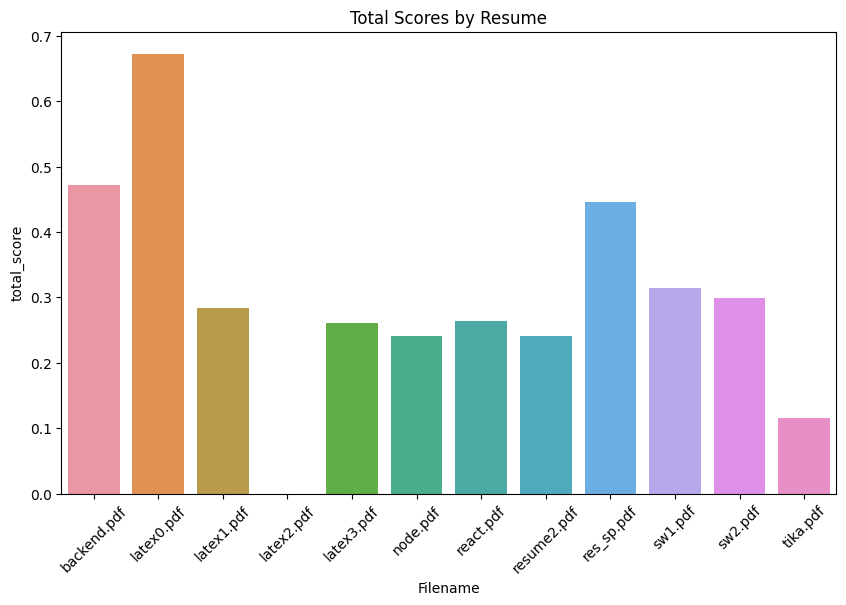

In [48]:
def visualize_total_scores(df_resume):
    # Bar chart for total scores using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Filename", y="total_score", data=df_resume)
    plt.xticks(rotation=45)
    plt.title("Total Scores by Resume")
    plt.show()

visualize_total_scores(df_resume)